In [3]:
import os
import sys

sys.path.append('/Users/dgood/timing_analysis/src')
# sys.path.append('/path/to/timing_analysis/src')

In [4]:
from pint.fitter import ConvergenceFailure
import pint.fitter
import pint.toa
import pint.models
from pint.utils import dmxparse

import astropy.units as u


In [5]:
%matplotlib notebook

In [6]:
import timing_analysis.lite_utils as lu
import timing_analysis.plot_utils as pu
from timing_analysis.utils import resid_stats, pdf_writer
from timing_analysis.timingconfiguration import TimingConfiguration

# Example of basic PINT timing

Let's load in a par & tim file, like we'd do in tempo or tempo2

In [7]:
timfile = 'sample_tims/J1744-1134_PINT_20220302.nb.tim'

In [8]:
parfile = 'sample_pars/J1744-1134_PINT_20221012_prenoise.ng_only.nb.par '

In [9]:
to = pint.toa.get_TOAs(timfile)

2022-11-28 11:22:13.213 | DEBUG    | pint.toa:apply_clock_corrections:2120 - Applying clock corrections (include_gps = True, include_bipm = True)
2022-11-28 11:22:14.973 | INFO     | pint.observatory:gps_correction:217 - Applying GPS to UTC clock correction (~few nanoseconds)
2022-11-28 11:22:14.974 | INFO     | pint.observatory:_load_gps_clock:94 - Loading global GPS clock file
2022-11-28 11:22:14.983 | DEBUG    | pint.observatory.clock_file:__init__:797 - Global clock file gps2utc.clk saving kwargs={'bogus_last_correction': False, 'valid_beyond_ends': False}
2022-11-28 11:22:14.989 | DEBUG    | pint.observatory.clock_file:read_tempo2_clock_file:460 - Loading TEMPO2-format observatory clock correction file /Users/dgood/.astropy/cache/download/url/d3c81b5766f4bfb84e65504c8a453085/contents with bogus_last_correction=False
2022-11-28 11:22:15.025 | INFO     | pint.observatory:find_clock_file:938 - Using global clock file for gps2utc.clk with bogus_last_correction=False
2022-11-28 11:22:1

Let's take a second and look at a PINT TOA object (which is itself an Astropy Table)

In [10]:
to.get_all_flags()

{'be',
 'bw',
 'chan',
 'clkcorr',
 'f',
 'fe',
 'flux',
 'fluxe',
 'format',
 'gof',
 'name',
 'nbin',
 'nch',
 'pout_gibbs',
 'proc',
 'pta',
 'simul',
 'snr',
 'subint',
 'tmplt',
 'to',
 'tobs',
 'ver',
 'wt'}

In [11]:
to.get_flag_value('be')

(['GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',
  'GASP',


But just a TOA on its own is pretty pointless - what about the model?

In [12]:
mo,to = pint.models.get_model_and_toas(parfile,timfile)

2022-11-28 11:25:06.116 | WARNING  | pint.models.noise_model:setup:113 - 'TNEQ1 -sys ['JBO.DFB.1520']' is provided by parameter EQUAD, using EQUAD instead. 
2022-11-28 11:25:06.117 | DEBUG    | pint.toa:get_TOAs:185 - Using EPHEM = DE440 from the given model
2022-11-28 11:25:06.118 | DEBUG    | pint.toa:get_TOAs:201 - Using CLOCK = BIPM2019 from the given model
2022-11-28 11:25:06.119 | DEBUG    | pint.toa:get_TOAs:216 - Using PLANET_SHAPIRO = True from the given model
2022-11-28 11:25:15.345 | DEBUG    | pint.toa:apply_clock_corrections:2120 - Applying clock corrections (include_gps = True, include_bipm = True)
2022-11-28 11:25:16.973 | INFO     | pint.observatory:gps_correction:217 - Applying GPS to UTC clock correction (~few nanoseconds)
2022-11-28 11:25:16.976 | INFO     | pint.observatory:bipm_correction:224 - Applying TT(TAI) to TT(BIPM2019) clock correction (~27 us)
2022-11-28 11:25:16.977 | INFO     | pint.observatory:_load_bipm_clock:105 - Loading BIPM clock version bipm2019
2

What really happened here?

In [13]:
to.print_summary()

Number of TOAs:  17745
Number of commands:  1
Number of observatories: 1 ['gbt']
MJD span:  53216.127 to 58940.432
Date span: 2004-07-30 03:02:26.251375710 to 2020-04-01 10:21:56.193156558
gbt TOAs (17745):
  Min freq:      724.687 MHz
  Max freq:      1880.945 MHz
  Min error:     0.04 us
  Max error:     14.3 us
  Median error:  1.01 us



And how is the model looking?

In [14]:
resids = pint.residuals.Residuals(to,mo)

2022-11-28 11:26:23.893 | INFO     | pint.solar_system_ephemerides:_load_kernel_link:53 - Set solar system ephemeris to de440 from download
2022-11-28 11:26:29.849 | DEBUG    | pint.toa:add_vel_ecl:2405 - Adding column ssb_obs_vel_ecl
2022-11-28 11:26:30.155 | DEBUG    | pint.models.absolute_phase:get_TZR_toa:97 - Creating and dealing with the single TZR_toa for absolute phase
2022-11-28 11:26:30.157 | DEBUG    | pint.toa:__init__:1315 - No pulse number flags found in the TOAs
2022-11-28 11:26:30.157 | DEBUG    | pint.toa:apply_clock_corrections:2120 - Applying clock corrections (include_gps = True, include_bipm = True)
2022-11-28 11:26:30.158 | INFO     | pint.observatory:gps_correction:217 - Applying GPS to UTC clock correction (~few nanoseconds)
2022-11-28 11:26:30.160 | INFO     | pint.observatory:bipm_correction:224 - Applying TT(TAI) to TT(BIPM2021) clock correction (~27 us)
2022-11-28 11:26:30.165 | DEBUG    | pint.observatory.clock_file:__init__:797 - Global clock file pks2gps.

In [15]:
mjds  = to.get_mjds()

In [16]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


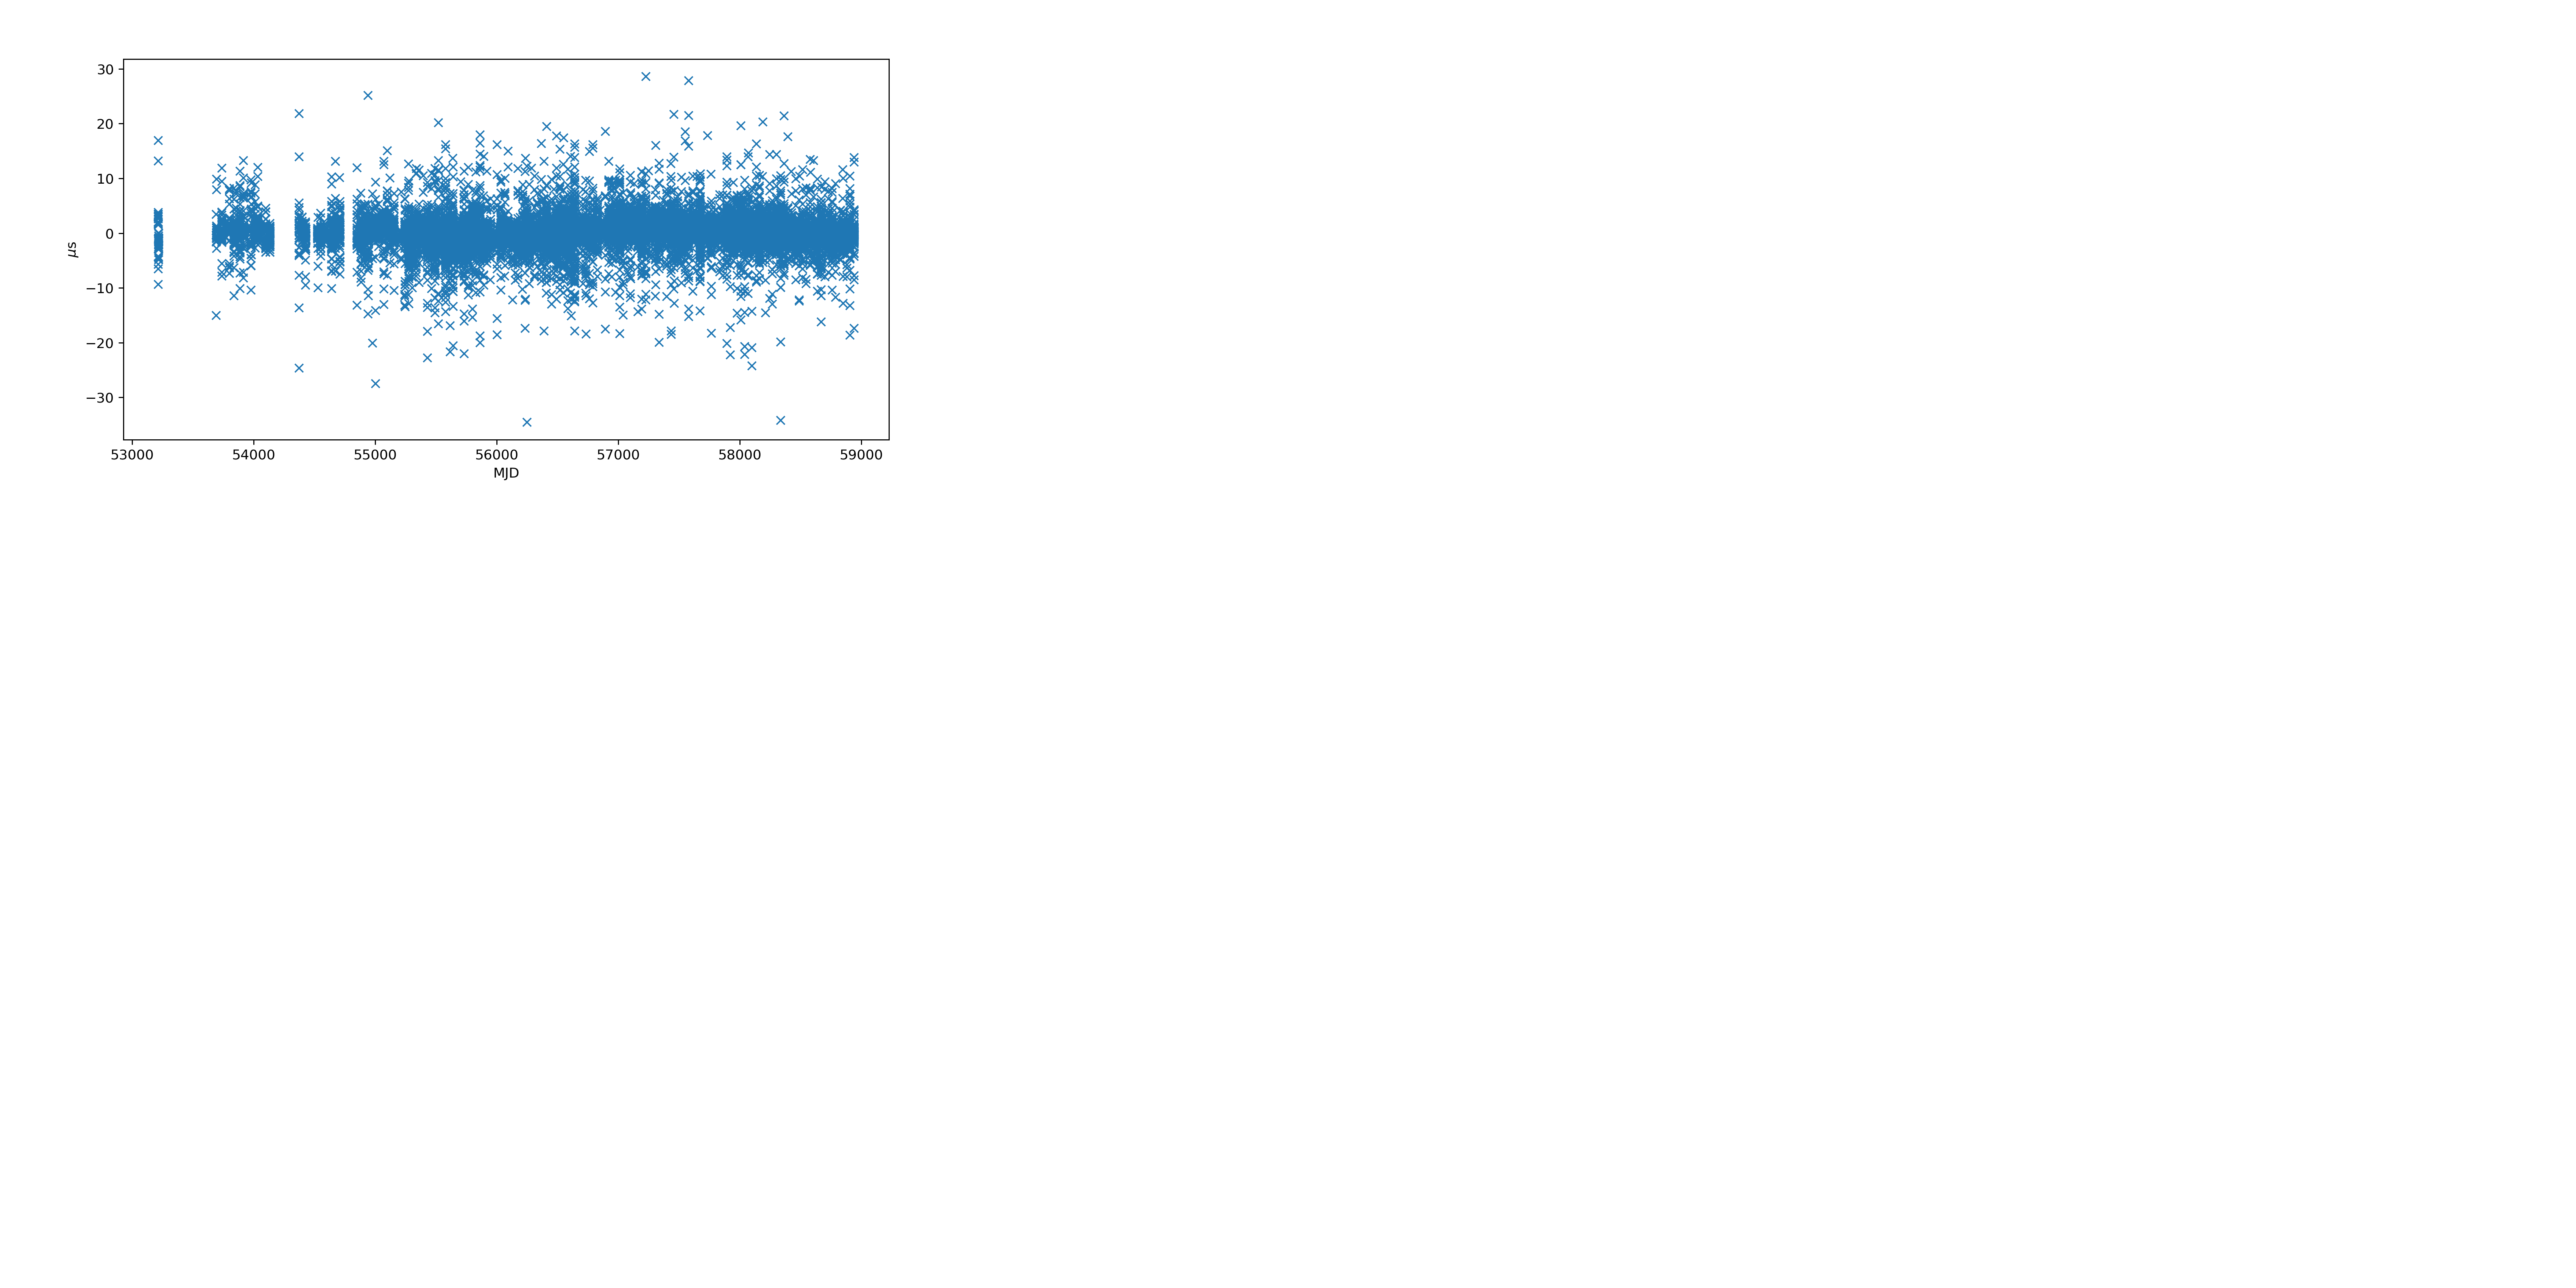

Text(0, 0.5, '$\\mu$s')

In [17]:
plt.figure(figsize=[10,5])
plt.plot(mjds,resids.time_resids * 10**6,'x')
plt.xlabel('MJD')
plt.ylabel(r'$\mu$s')

Now let's suppose we do not have a good par file to start, and we need to fit. 

In [18]:
f = pint.fitter.WLSFitter(to, mo)
f.fit_toas() 

/Users/dgood/opt/anaconda3/lib/python3.8/site-packages/pint/models/noise_model.py:163: UserWarning: EQUAD maskParameter(EQUAD1 -sys JBO.DFB.1520 0.8455903147665146 (us)) has no TOAs
  warnings.warn(f"EQUAD {equad} has no TOAs")
/Users/dgood/opt/anaconda3/lib/python3.8/site-packages/pint/models/noise_model.py:163: UserWarning: EQUAD maskParameter(EQUAD1 -sys JBO.DFB.1520 0.8455903147665146 (us)) has no TOAs
  warnings.warn(f"EQUAD {equad} has no TOAs")
2022-11-28 11:28:02.298 | DEBUG    | pint.models.absolute_phase:get_TZR_toa:97 - Creating and dealing with the single TZR_toa for absolute phase
2022-11-28 11:28:02.301 | DEBUG    | pint.toa:__init__:1315 - No pulse number flags found in the TOAs
2022-11-28 11:28:02.301 | DEBUG    | pint.toa:apply_clock_corrections:2120 - Applying clock corrections (include_gps = True, include_bipm = True)
2022-11-28 11:28:02.302 | INFO     | pint.observatory:gps_correction:217 - Applying GPS to UTC clock correction (~few nanoseconds)
2022-11-28 11:28:02.

80623.3891083762777

In [19]:
f.print_summary()

/Users/dgood/opt/anaconda3/lib/python3.8/site-packages/pint/models/noise_model.py:163: UserWarning: EQUAD maskParameter(EQUAD1 -sys JBO.DFB.1520 0.8455903147665146 (us)) has no TOAs
  warnings.warn(f"EQUAD {equad} has no TOAs")
/Users/dgood/opt/anaconda3/lib/python3.8/site-packages/pint/models/noise_model.py:163: UserWarning: EQUAD maskParameter(EQUAD1 -sys JBO.DFB.1520 0.8455903147665146 (us)) has no TOAs
  warnings.warn(f"EQUAD {equad} has no TOAs")


Fitted model using weighted_least_square method with 8 free parameters to 17745 TOAs
Prefit residuals Wrms = 0.9037507840527361 us, Postfit residuals Wrms = 0.8892467444269657 us
Chisq = 80623.389 for 17736 d.o.f. for reduced Chisq of 4.546

PAR                        Prefit                  Postfit            Units
=================== ==================== ============================ =====
PSR                           J1744-1134 J1744-1134                   None
EPHEM                              DE440 DE440                        None
CLOCK                       TT(BIPM2019) TT(BIPM2019)                 None
UNITS                                TDB TDB                          None
START                            53041.1                      53216.1 d 
FINISH                           59664.9                      58940.4 d 
TIMEEPH                             FB90 FB90                         None
T2CMETHOD                       IAU2000B IAU2000B                     None
DILATEFREQ

In [20]:
postfit_resids = f.resids.time_resids.to(u.us)

In [21]:
errors = to.get_errors()

<IPython.core.display.Javascript object>


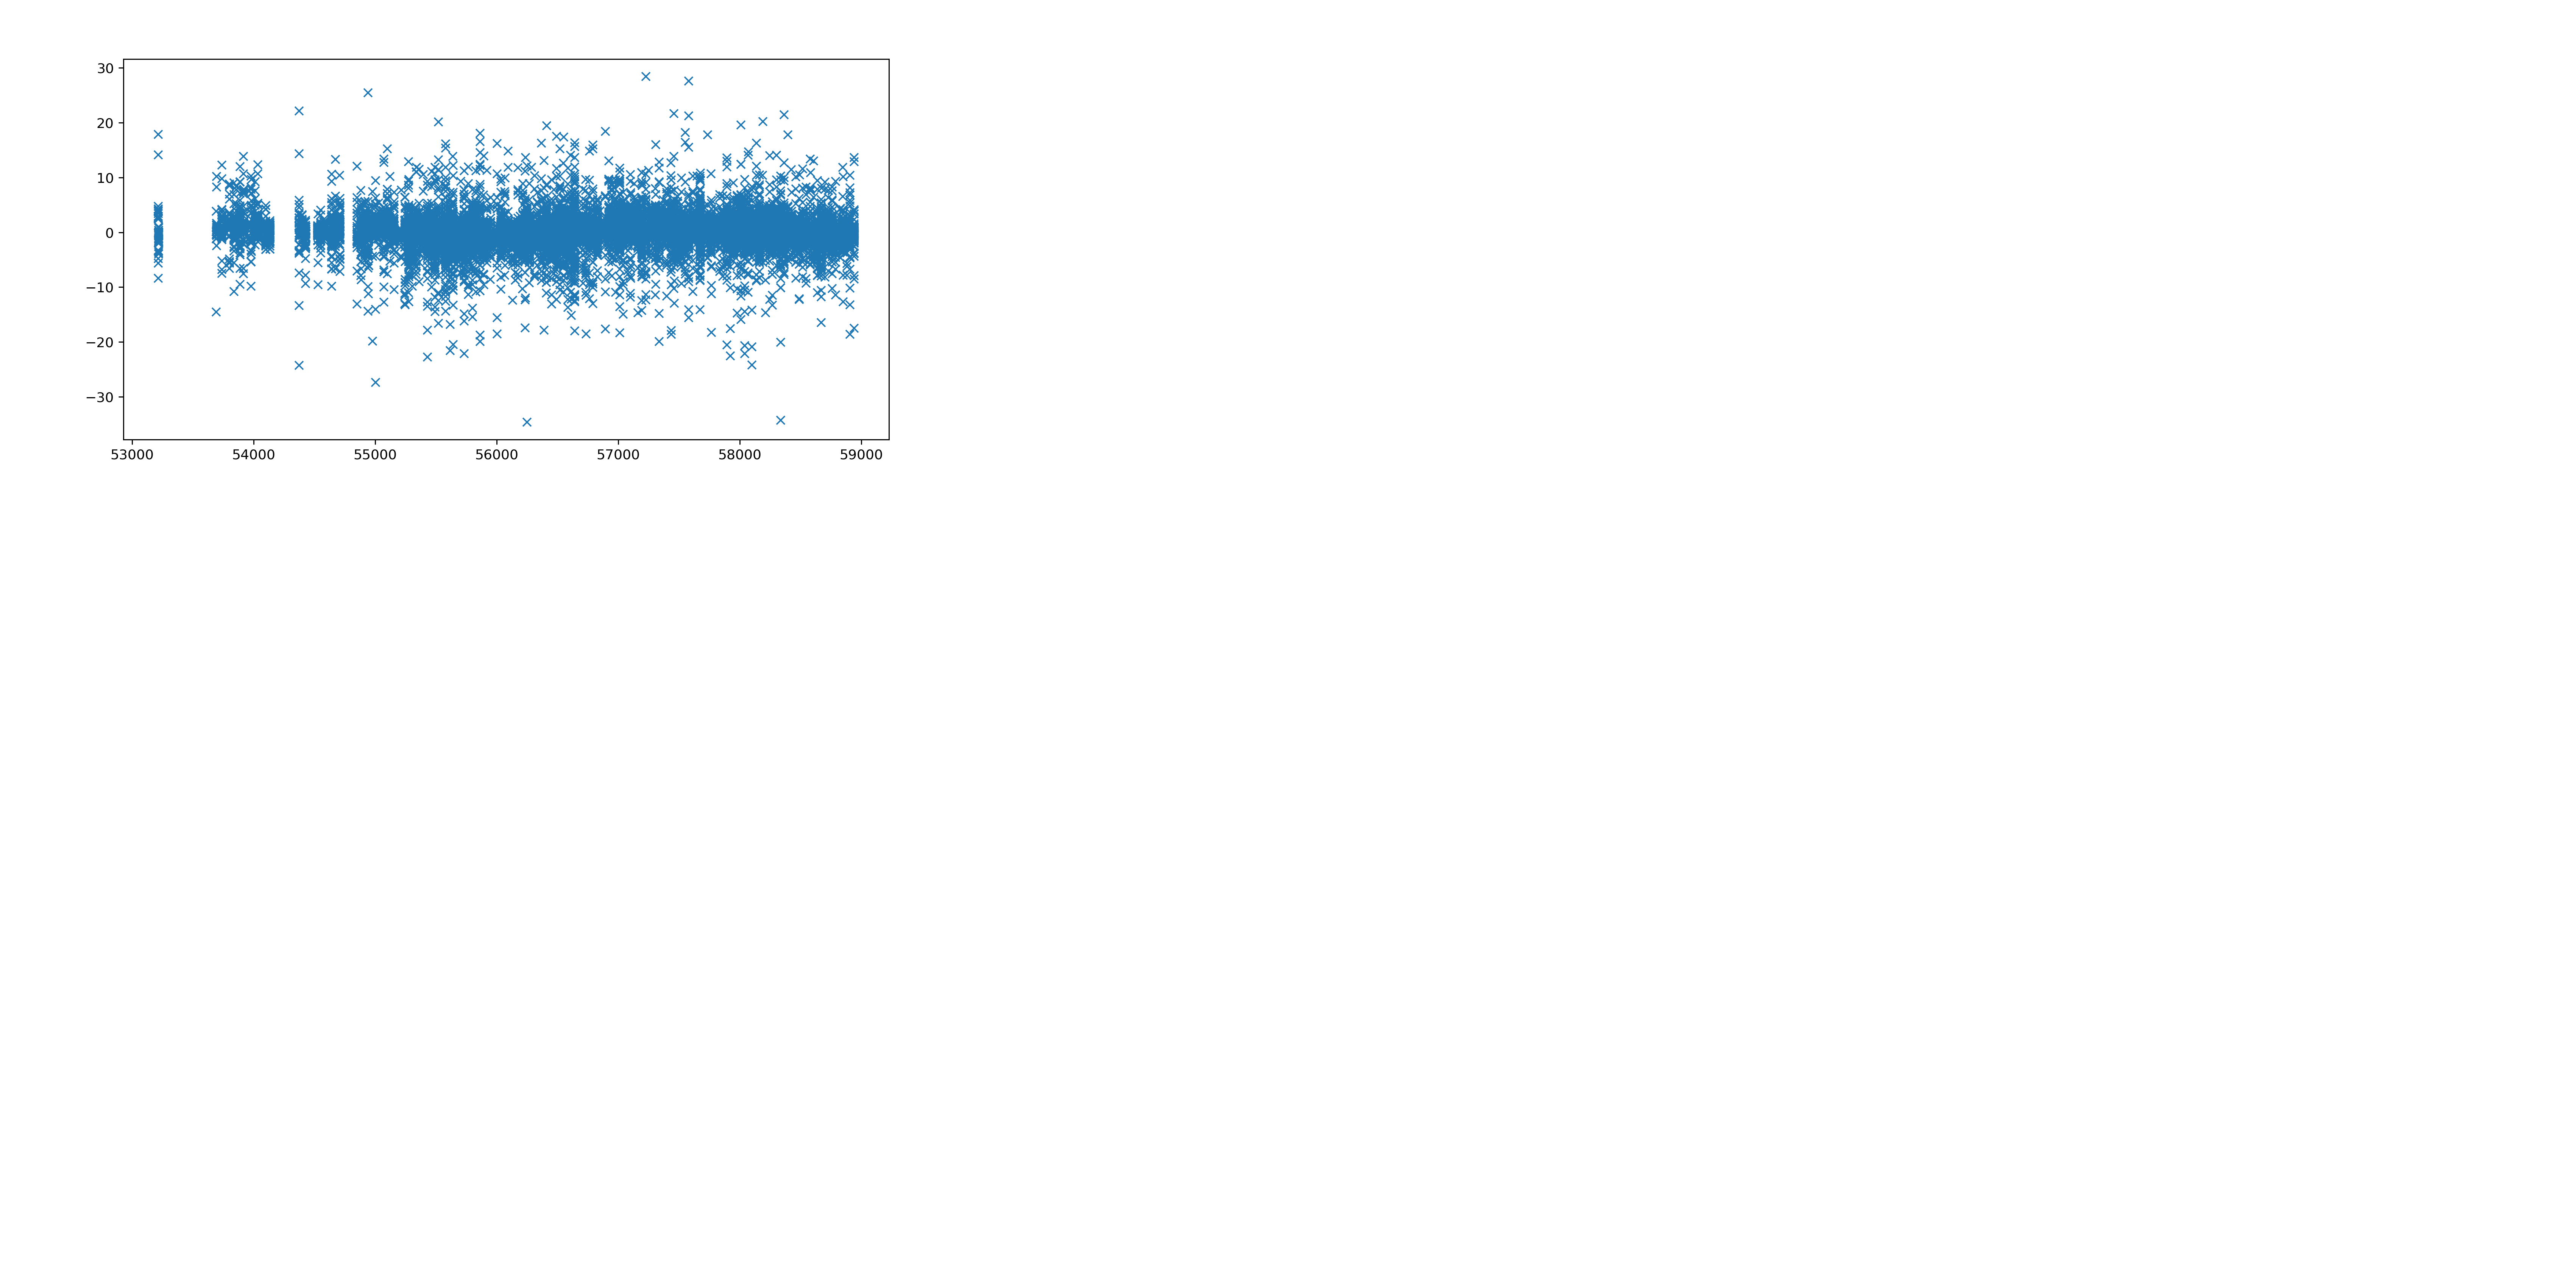

In [22]:
plt.figure(figsize=[10,5])

plt.plot(mjds, postfit_resids,'x')

# The timing_analysis framework

But this will quickly get unwieldy when we have a lot of different files and a lot of of different fitting and so on...what do we do?

Enter the config file

In [36]:
config = 'sample_configs/J1744-1134.ngonly.nb.yaml'
par_directory = None   # default location
tim_directory = None   # default location
tc = TimingConfiguration(config)


In [38]:
mo,to = tc.get_model_and_toas(usepickle=False, include_pn=False)


2022-11-28 11:49:07.641 | WARNING  | pint.models.noise_model:setup:113 - 'TNEQ1 -sys ['JBO.DFB.1520']' is provided by parameter EQUAD, using EQUAD instead. 
2022-11-28 11:49:07.641 | WARNING  | pint.models.noise_model:setup:113 - 'TNEQ2 -sys ['EFF.EBPP.1360']' is provided by parameter EQUAD, using EQUAD instead. 
2022-11-28 11:49:07.642 | WARNING  | pint.models.noise_model:setup:113 - 'TNEQ3 -sys ['EFF.EBPP.1410']' is provided by parameter EQUAD, using EQUAD instead. 
2022-11-28 11:49:07.643 | WARNING  | pint.models.noise_model:setup:113 - 'TNEQ4 -sys ['EFF.EBPP.2639']' is provided by parameter EQUAD, using EQUAD instead. 
2022-11-28 11:49:07.643 | WARNING  | pint.models.noise_model:setup:113 - 'TNEQ5 -sys ['NRT.BON.1400']' is provided by parameter EQUAD, using EQUAD instead. 
2022-11-28 11:49:07.644 | WARNING  | pint.models.noise_model:setup:113 - 'TNEQ6 -sys ['NRT.BON.1600']' is provided by parameter EQUAD, using EQUAD instead. 
2022-11-28 11:49:07.644 | WARNING  | pint.models.noise_

INFO: Par file created: 2022-10-12T16:41:49.067007 [timing_analysis.timingconfiguration]


2022-11-28 11:49:16.308 | WARNING  | pint.toa:read_toa_file:794 - Unknown command MODE in line MODE 1

2022-11-28 11:49:19.053 | DEBUG    | pint.toa:__init__:1315 - No pulse number flags found in the TOAs
2022-11-28 11:49:19.058 | WARNING  | pint.toa:merge_TOAs:2485 - 'pulse_number' not present in data set 1: inserting NaNs
2022-11-28 11:49:19.766 | DEBUG    | pint.toa:apply_clock_corrections:2120 - Applying clock corrections (include_gps = True, include_bipm = True)
2022-11-28 11:49:21.034 | INFO     | pint.observatory:gps_correction:217 - Applying GPS to UTC clock correction (~few nanoseconds)
2022-11-28 11:49:21.036 | INFO     | pint.observatory:bipm_correction:224 - Applying TT(TAI) to TT(BIPM2019) clock correction (~27 us)
2022-11-28 11:49:21.038 | INFO     | pint.observatory.topo_obs:clock_corrections:355 - Applying observatory clock corrections for observatory='gbt'.
2022-11-28 11:49:27.887 | INFO     | pint.observatory:gps_correction:217 - Applying GPS to UTC clock correction (

INFO: Frontend/backend pairs present in this data set: {'1050CM_PDFB2', 'MULTI_PDFB2', 'UWL_Medusa', 'MULTI_CPSR2m', 'Rcvr_800_GUPPI', '1050CM_PDFB3', 'H-OH_PDFB4', 'MULTI_CPSR2n', 'H-OH_PDFB1', '1050CM_CASPSR', 'UWL_CASPSR', 'MULTI_PDFB1', 'Rcvr1_2_GUPPI', 'H-OH_CPSR2n', 'UWL_PDFB4', 'Rcvr_800_GASP', '1050CM_WBCORR', 'MULTI_PDFB3', 'H-OH_CPSR2m', 'Rcvr1_2_GASP', '1050CM_CPSR2', '1050CM_PDFB1', 'MULTI_PDFB4', '1050CM_PDFB4'} [timing_analysis.timingconfiguration]
INFO: 1050CM_PDFB2 files: 17 [timing_analysis.timingconfiguration]
INFO: MULTI_PDFB2 files: 26 [timing_analysis.timingconfiguration]
INFO: UWL_Medusa files: 604 [timing_analysis.timingconfiguration]
INFO: MULTI_CPSR2m files: 36 [timing_analysis.timingconfiguration]
INFO: Rcvr_800_GUPPI files: 122 [timing_analysis.timingconfiguration]
INFO: 1050CM_PDFB3 files: 106 [timing_analysis.timingconfiguration]
INFO: H-OH_PDFB4 files: 30 [timing_analysis.timingconfiguration]
INFO: MULTI_CPSR2n files: 31 [timing_analysis.timingconfiguratio

In [39]:
to.print_summary()

Number of TOAs:  23280
Number of commands:  [1, 2]
Number of observatories: 2 ['gbt', 'parkes']
MJD span:  53041.073 to 59664.937
Date span: 2004-02-06 01:44:41.134521377 to 2022-03-26 22:29:53.589854808
gbt TOAs (17745):
  Min freq:      724.687 MHz
  Max freq:      1880.945 MHz
  Min error:     0.04 us
  Max error:     14.3 us
  Median error:  1.01 us
parkes TOAs (5535):
  Min freq:      662.350 MHz
  Max freq:      3852.340 MHz
  Min error:     0.031 us
  Max error:     4.71 us
  Median error:  0.885 us



2022-11-28 11:51:42.527 | INFO     | pint.fitter:__init__:1598 - Model does not appear to have correlated errors so the GLS fitter is unnecessary; DownhillWLSFitter may be faster and more stable.
2022-11-28 11:51:46.196 | INFO     | pint.solar_system_ephemerides:_load_kernel_link:53 - Set solar system ephemeris to de440 from download
2022-11-28 11:51:51.781 | INFO     | pint.solar_system_ephemerides:_load_kernel_link:53 - Set solar system ephemeris to de440 from download
2022-11-28 11:51:53.675 | DEBUG    | pint.toa:add_vel_ecl:2405 - Adding column ssb_obs_vel_ecl
2022-11-28 11:51:56.813 | DEBUG    | pint.models.absolute_phase:get_TZR_toa:97 - Creating and dealing with the single TZR_toa for absolute phase
2022-11-28 11:51:56.815 | DEBUG    | pint.toa:__init__:1315 - No pulse number flags found in the TOAs
2022-11-28 11:51:56.816 | DEBUG    | pint.toa:apply_clock_corrections:2120 - Applying clock corrections (include_gps = True, include_bipm = True)
2022-11-28 11:51:56.816 | INFO     |

/Users/dgood/opt/anaconda3/lib/python3.8/site-packages/pint/models/noise_model.py:170: UserWarning: EFAC maskParameter(EFAC5 -sys JBO.DFB.1520 0.768039 ()) has no TOAs
  warnings.warn(f"EFAC {efac} has no TOAs")
/Users/dgood/opt/anaconda3/lib/python3.8/site-packages/pint/models/noise_model.py:170: UserWarning: EFAC maskParameter(EFAC6 -sys EFF.EBPP.1360 0.577213 ()) has no TOAs
  warnings.warn(f"EFAC {efac} has no TOAs")
/Users/dgood/opt/anaconda3/lib/python3.8/site-packages/pint/models/noise_model.py:170: UserWarning: EFAC maskParameter(EFAC7 -sys EFF.EBPP.1410 1.02995 ()) has no TOAs
  warnings.warn(f"EFAC {efac} has no TOAs")
/Users/dgood/opt/anaconda3/lib/python3.8/site-packages/pint/models/noise_model.py:170: UserWarning: EFAC maskParameter(EFAC8 -sys EFF.EBPP.2639 0.880022 ()) has no TOAs
  warnings.warn(f"EFAC {efac} has no TOAs")
/Users/dgood/opt/anaconda3/lib/python3.8/site-packages/pint/models/noise_model.py:170: UserWarning: EFAC maskParameter(EFAC9 -sys NRT.BON.1400 1.43313

<IPython.core.display.Javascript object>


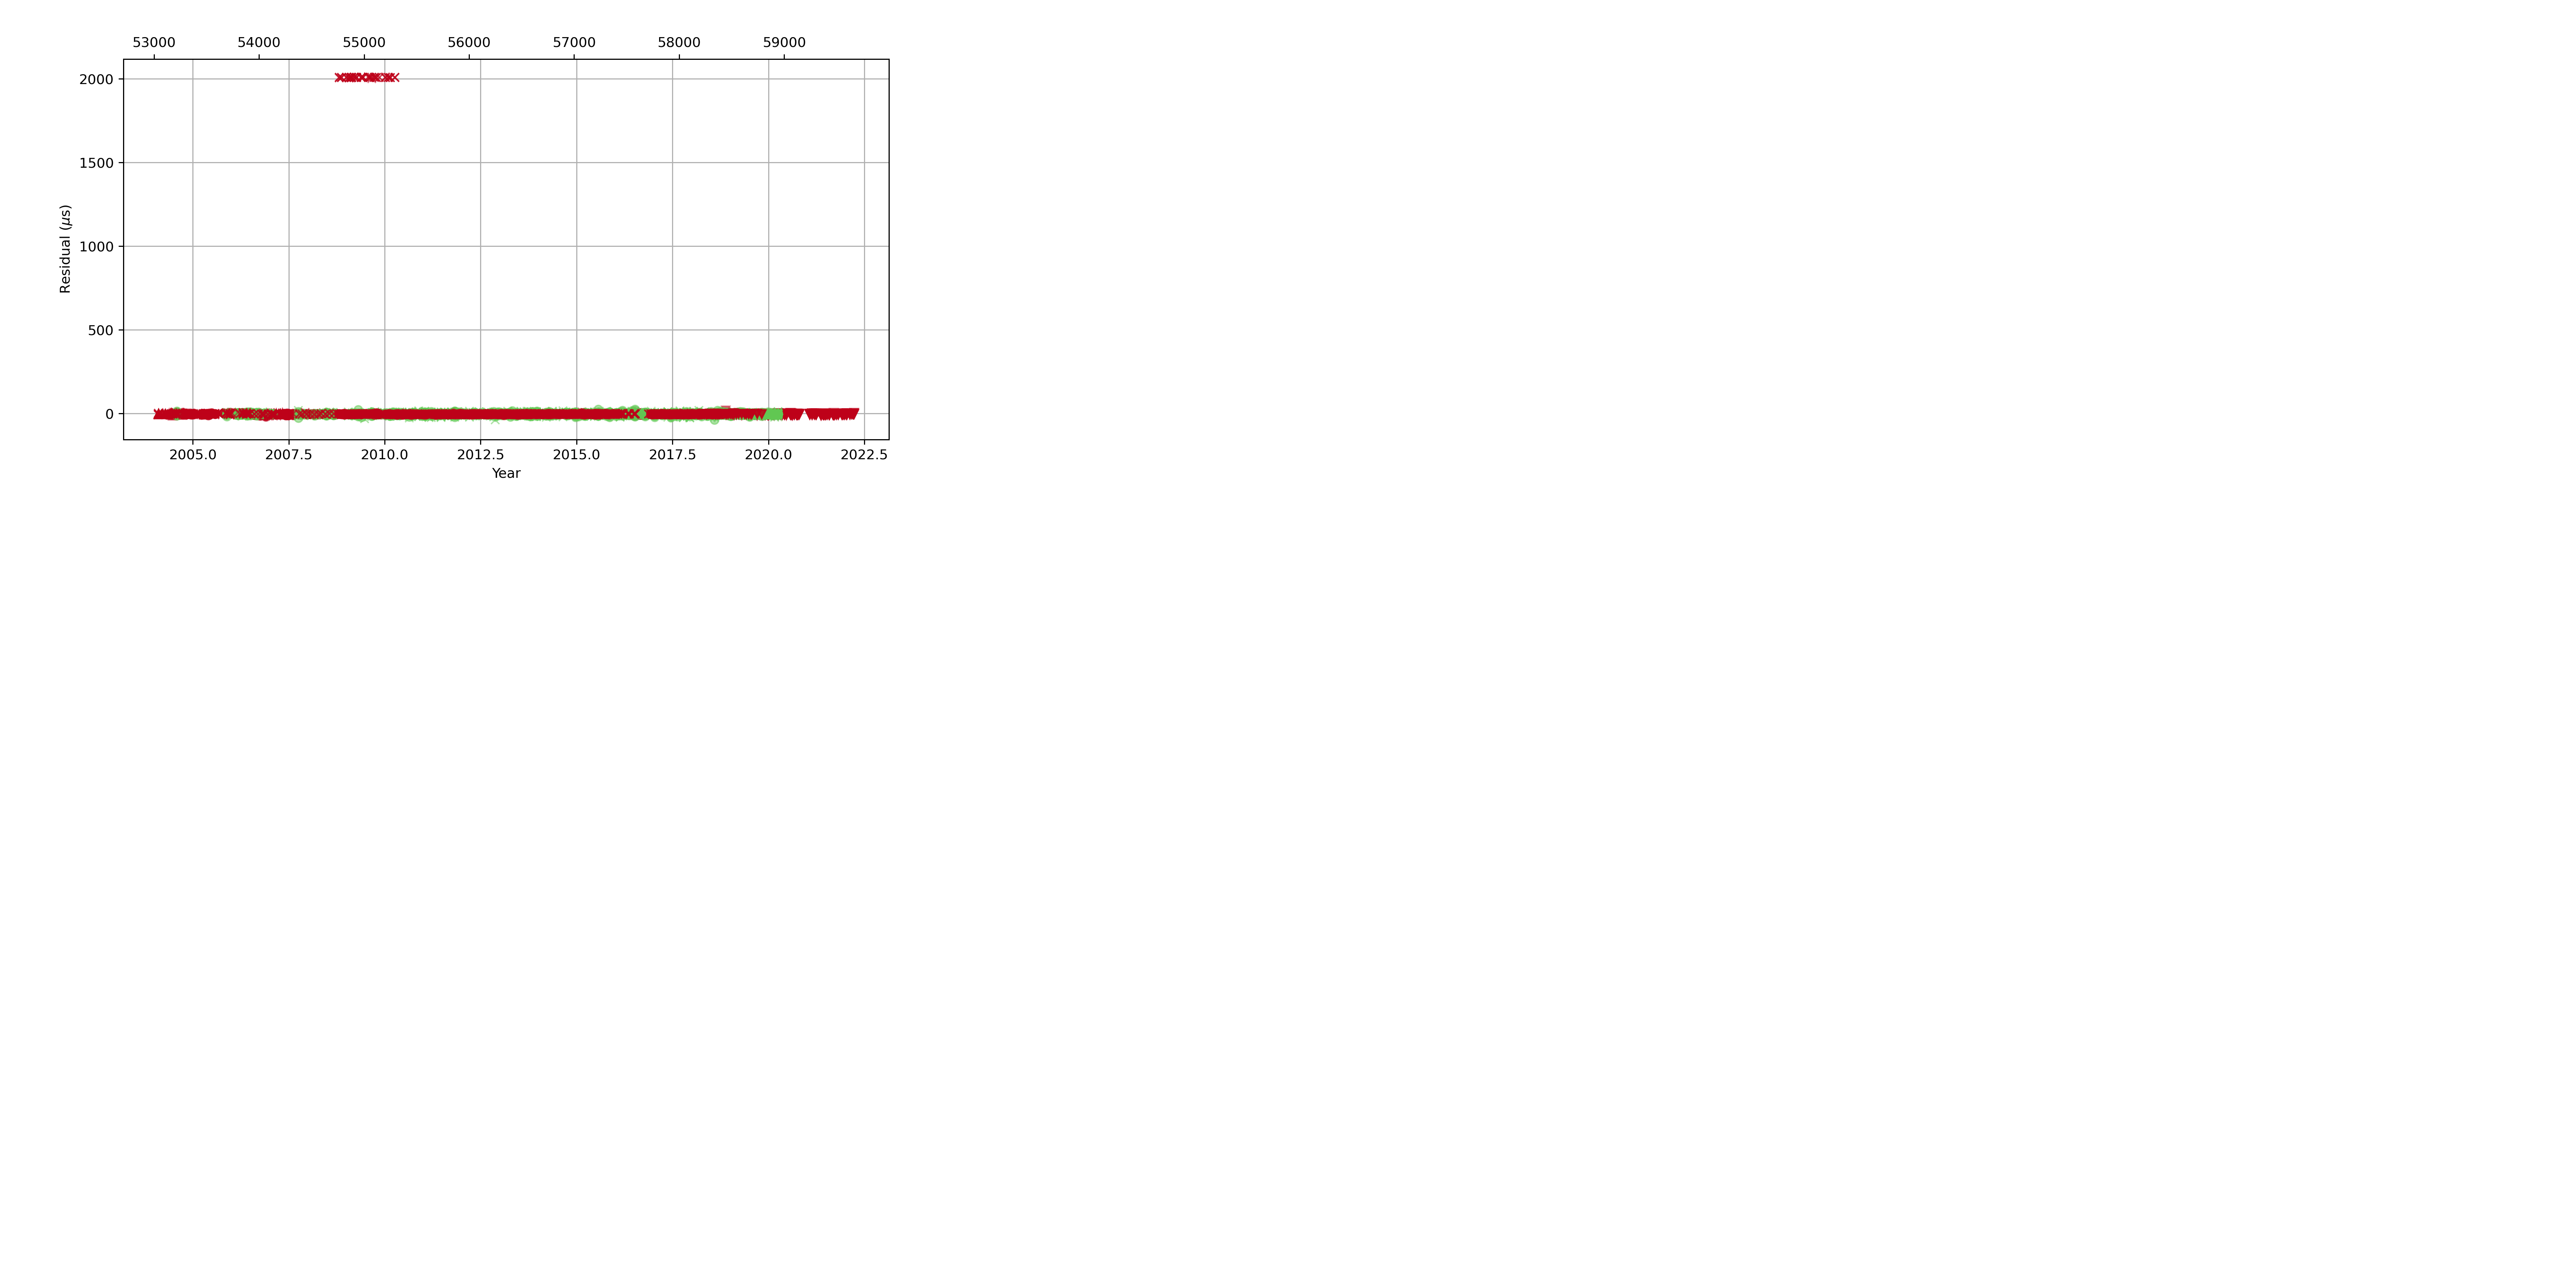

/Users/dgood/timing_analysis/src/timing_analysis/plot_utils.py:453: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


In [40]:
fo = tc.construct_fitter(to,mo)
pu.plot_residuals_time(fo, restype='prefit')

In [41]:
# Check that free-params follow NANOGrav conventions, fit
fo.model.free_params = tc.get_free_params(fo)
print(fo.model.free_params)
lu.check_fit(fo,skip_check=tc.skip_check)

['PX', 'ELONG', 'ELAT', 'PMELONG', 'PMELAT', 'F0', 'F1', 'JUMP1']


In [30]:

try:
    fo.fit_toas(maxiter=tc.get_niter())
    fo.model.CHI2.value = fo.resids.chi2
except ConvergenceFailure:
    run_Ftest = False
    log.warning('Failed to converge; moving on with best result, but should address before final version.')

2022-11-28 11:42:00.898 | DEBUG    | pint.models.absolute_phase:get_TZR_toa:97 - Creating and dealing with the single TZR_toa for absolute phase
2022-11-28 11:42:00.901 | DEBUG    | pint.toa:__init__:1315 - No pulse number flags found in the TOAs
2022-11-28 11:42:00.901 | DEBUG    | pint.toa:apply_clock_corrections:2120 - Applying clock corrections (include_gps = True, include_bipm = True)
2022-11-28 11:42:00.903 | INFO     | pint.observatory:gps_correction:217 - Applying GPS to UTC clock correction (~few nanoseconds)
2022-11-28 11:42:00.904 | INFO     | pint.observatory:bipm_correction:224 - Applying TT(TAI) to TT(BIPM2021) clock correction (~27 us)
2022-11-28 11:42:00.905 | INFO     | pint.observatory.topo_obs:clock_corrections:355 - Applying observatory clock corrections for observatory='gbt'.
2022-11-28 11:42:00.909 | DEBUG    | pint.toa:compute_TDBs:2170 - Computing TDB columns.
2022-11-28 11:42:00.910 | DEBUG    | pint.toa:compute_TDBs:2195 - Using EPHEM = DE440 for TDB calculati

2022-11-28 11:42:24.202 | DEBUG    | pint.toa:compute_posvels:2355 - Adding columns ssb_obs_pos ssb_obs_vel obs_sun_pos obs_jupiter_pos obs_saturn_pos obs_venus_pos obs_uranus_pos obs_neptune_pos obs_earth_pos
2022-11-28 11:42:24.204 | DEBUG    | pint.models.absolute_phase:get_TZR_toa:110 - Done with TZR_toa
2022-11-28 11:42:24.346 | INFO     | pint.solar_system_ephemerides:_load_kernel_link:53 - Set solar system ephemeris to de440 from download
2022-11-28 11:42:24.399 | DEBUG    | pint.toa:add_vel_ecl:2405 - Adding column ssb_obs_vel_ecl
2022-11-28 11:42:30.522 | DEBUG    | pint.fitter:fit_toas:1278 - Iteration 0: chi2 does not improve, stopping; decrease: 0.004423248974696037


In [31]:
fo.print_summary()

Fitted model using downhill_gls method with 177 free parameters to 17745 TOAs
Prefit residuals Wrms = 0.6320797907208222 us, Postfit residuals Wrms = 0.6320438845634456 us
Chisq = 17538.107 for 17567 d.o.f. for reduced Chisq of 0.998

PAR                        Prefit                  Postfit            Units
=================== ==================== ============================ =====
PSR                           J1744-1134 J1744-1134                   None
EPHEM                              DE440 DE440                        None
CLOCK                       TT(BIPM2019) TT(BIPM2019)                 None
UNITS                                TDB TDB                          None
START                            53216.1                      53216.1 d 
FINISH                           58940.4                      58940.4 d 
INFO                                  -f -f                           None
TIMEEPH                             FB90 FB90                         None
T2CMETHOD        

<IPython.core.display.Javascript object>


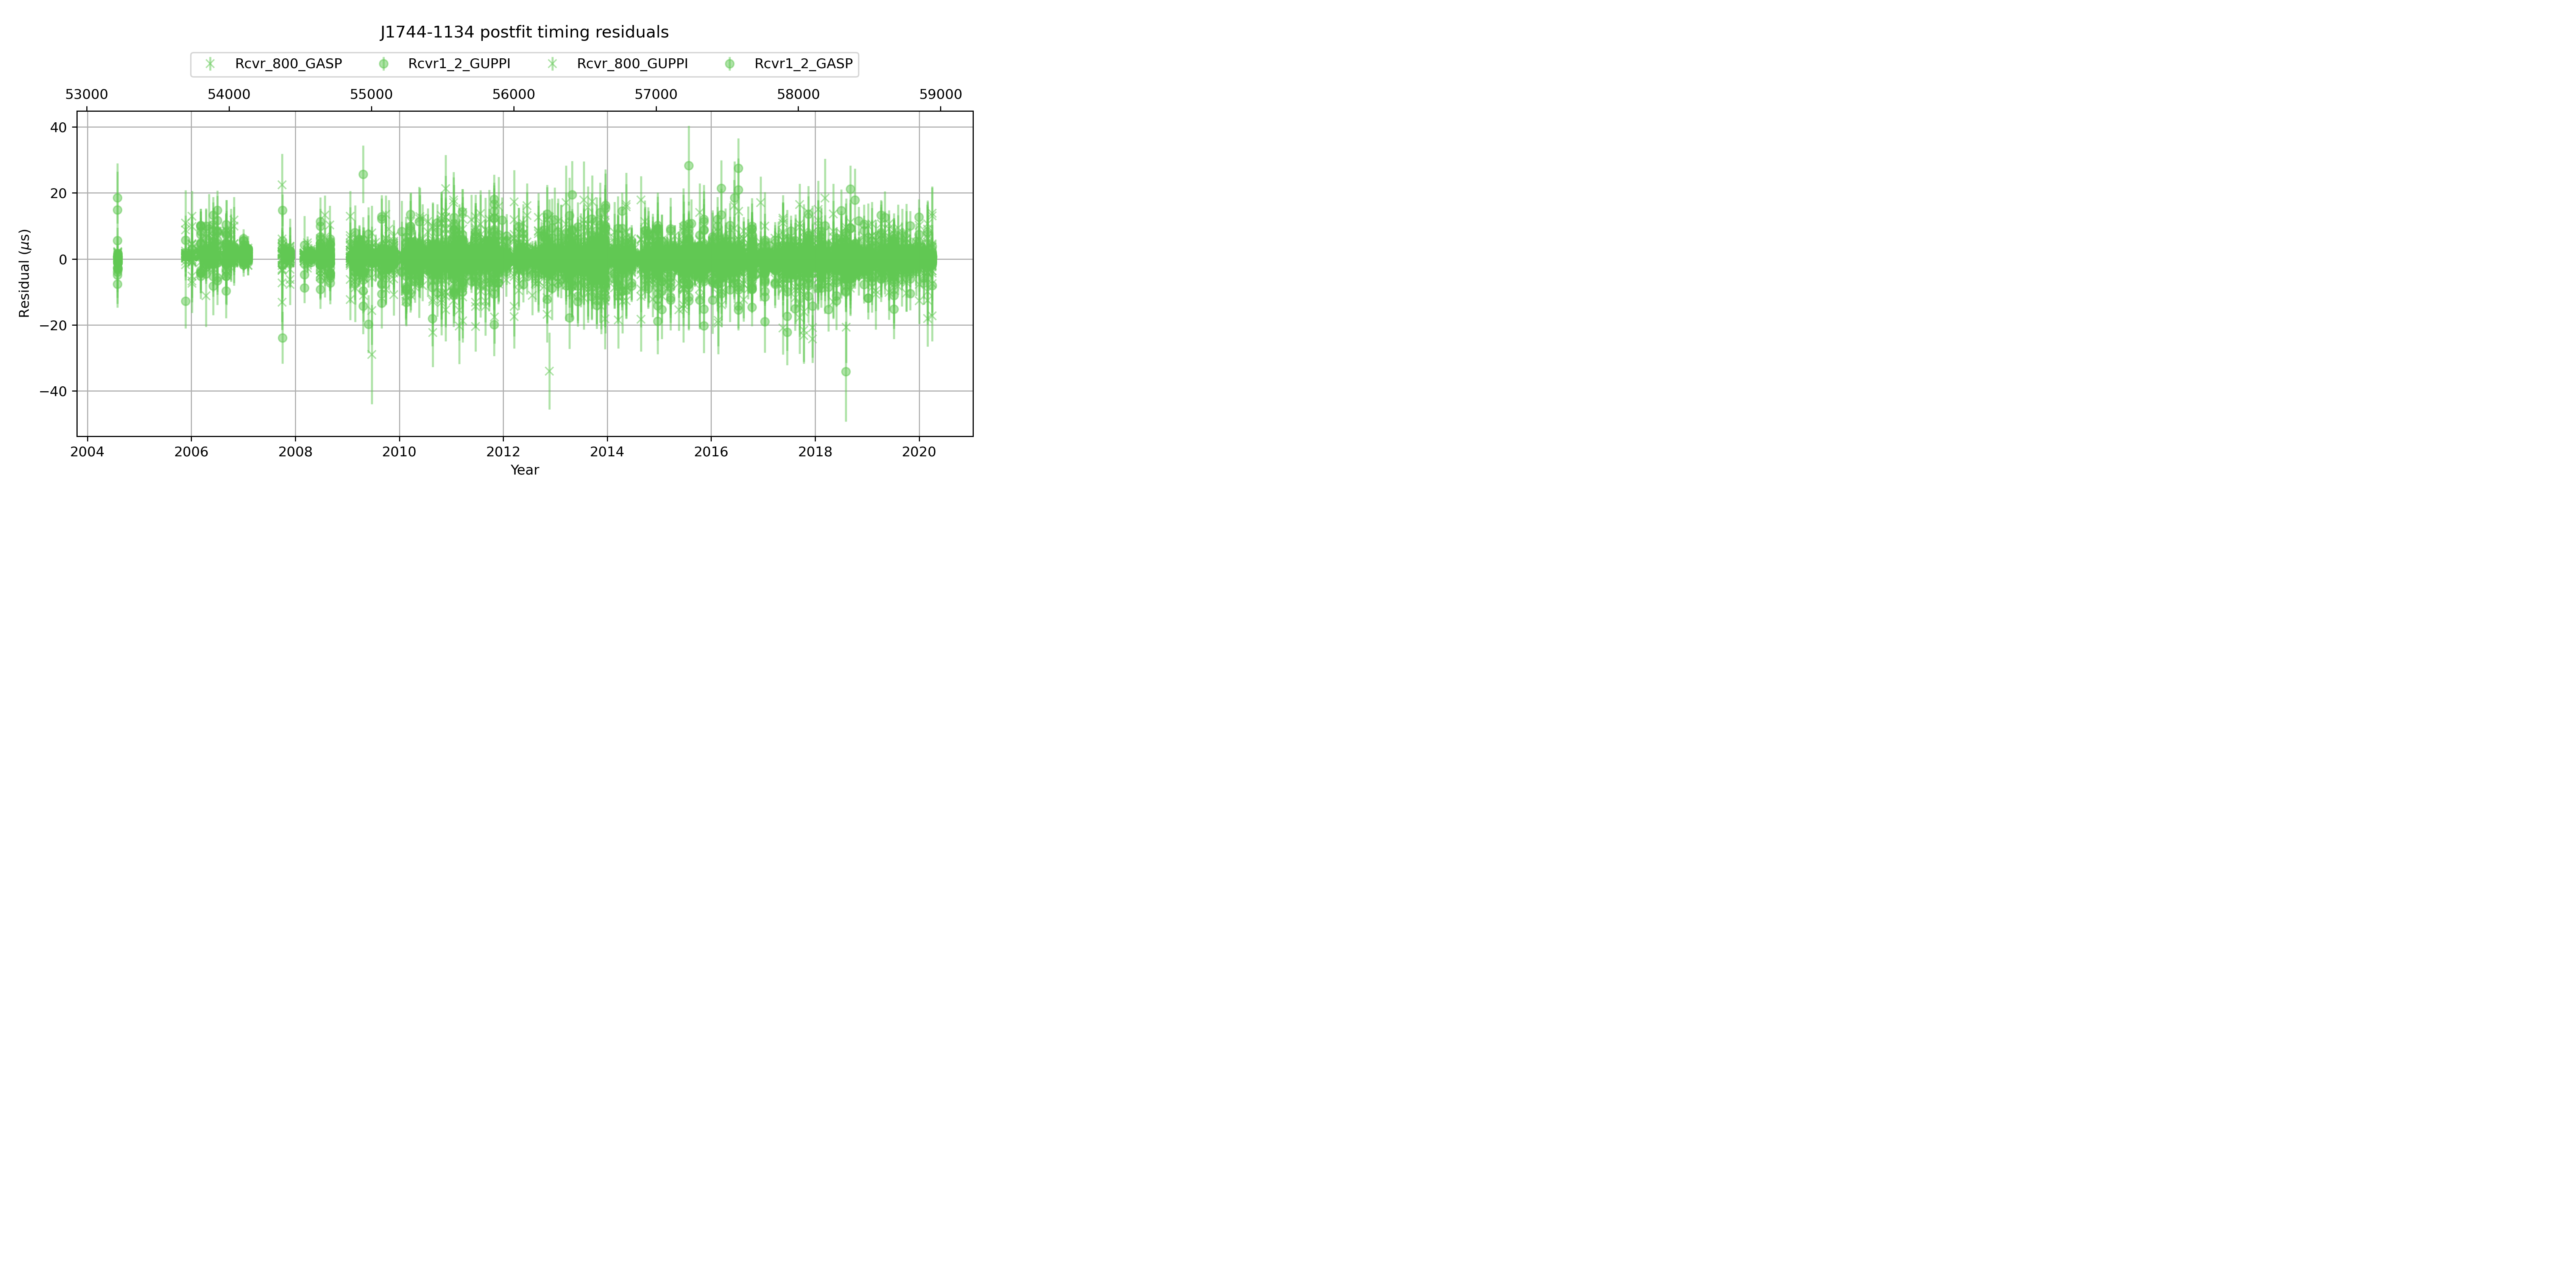

In [32]:
pu.plot_residuals_time(fo, restype='postfit')